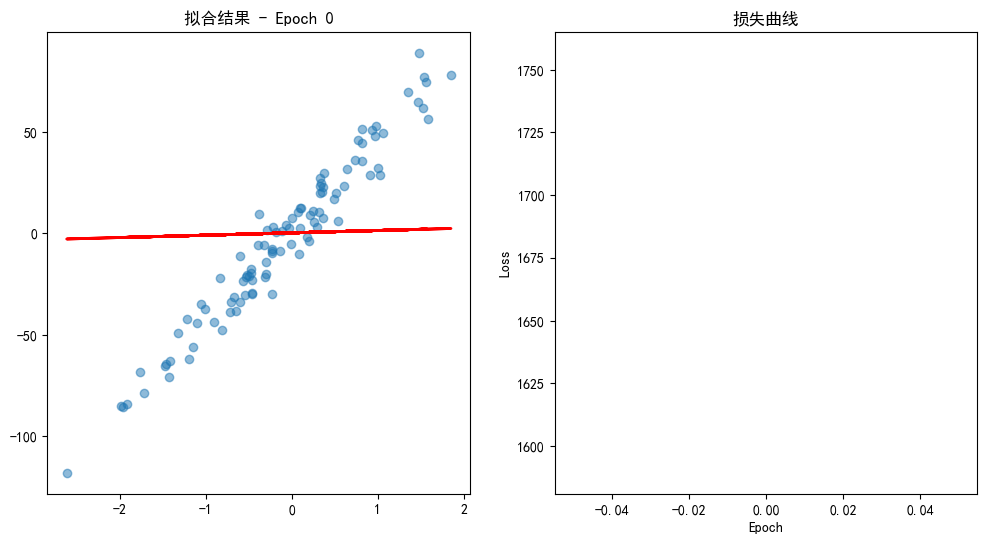

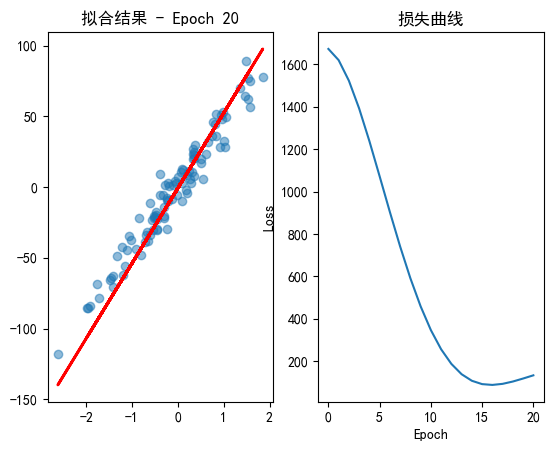

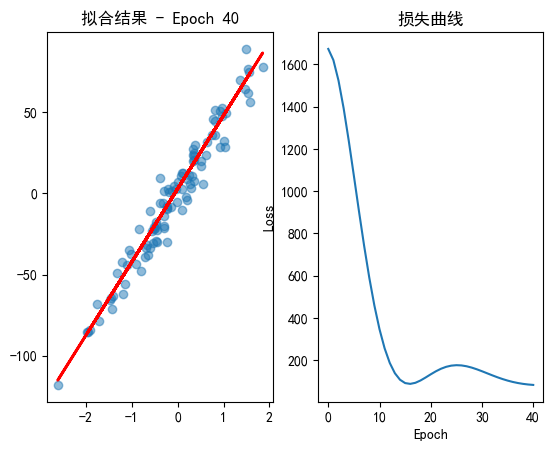

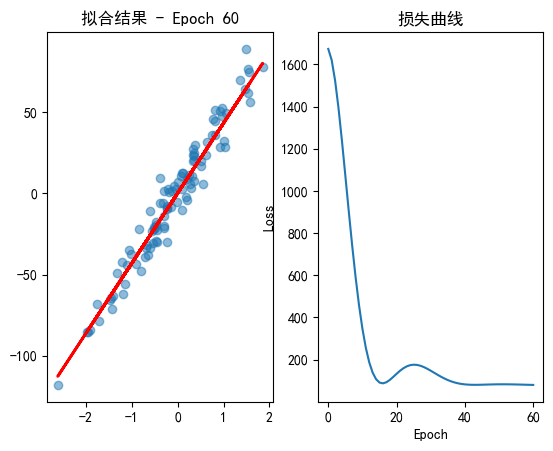

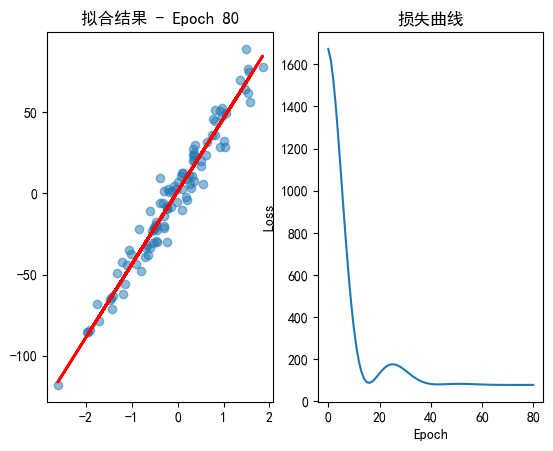

训练完成！
最终损失: 78.0601

SGD优化器内部运算过程:
1. 计算梯度: grad = ∂Loss/∂w
2. 更新速度项: v = momentum * v + grad
3. 更新参数: w = w - learning_rate * v

其中:
- learning_rate 控制每次更新的步长
- momentum 帮助优化器在相关方向上加速并减少震荡
- 当momentum=0时，SGD退化为普通的梯度下降


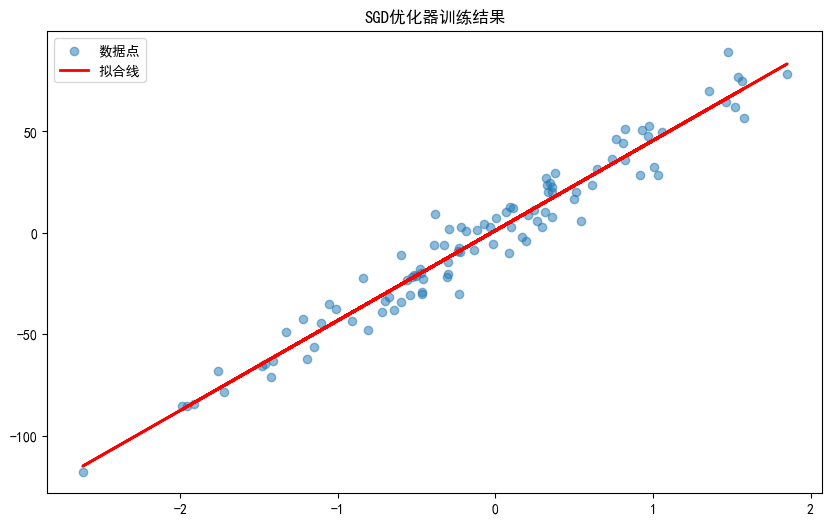


最终模型参数:
linear.weight: [44.352985]
linear.bias: [1.1779157]


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_regression
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib as mpl

# 设置matplotlib支持中文显示
plt.rcParams['font.sans-serif'] = ['SimHei']  # 用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False    # 用来正常显示负号

# 生成一些随机数据
X_np, y_np = make_regression(n_samples=100, n_features=1, noise=10, random_state=42)
# 将NumPy数组转换为float32类型
X = X_np.astype(np.float32)
y = y_np.astype(np.float32).reshape(-1, 1)

# 转换为PyTorch张量
X_tensor = torch.from_numpy(X)
y_tensor = torch.from_numpy(y)

# 定义一个简单的线性模型
class LinearModel(nn.Module):
    def __init__(self):
        super(LinearModel, self).__init__()
        # 创建一个线性层，输入维度为1，输出维度为1
        self.linear = nn.Linear(1, 1)
    
    def forward(self, x):
        # 前向传播，返回线性变换的结果
        return self.linear(x)

# 初始化模型
model = LinearModel()

# 定义损失函数 - 均方误差
criterion = nn.MSELoss()

# 使用SGD优化器
learning_rate = 0.01  # 学习率
momentum = 0.9        # 动量参数
# 创建SGD优化器实例，传入模型参数、学习率和动量
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum)

# 手动实现SGD优化过程，帮助理解内部运算
def manual_sgd_step(params, grads, velocities, lr=0.01, momentum=0.9):
    """
    手动实现SGD优化步骤
    params: 模型参数
    grads: 参数梯度
    velocities: 速度项（用于momentum）
    lr: 学习率
    momentum: 动量系数
    """
    for i, (param, grad) in enumerate(zip(params, grads)):
        # 更新速度项: v = momentum * v + grad
        velocities[i] = momentum * velocities[i] + grad
        # 更新参数: w = w - lr * v
        param.data.sub_(lr * velocities[i])  # sub_是原地减法操作
    return velocities

# 训练模型
epochs = 100  # 训练轮数
losses = []   # 存储每轮的损失值
# 为手动SGD创建参数副本
manual_params = [p.clone().detach() for p in model.parameters()]
# 初始化速度项为0
manual_velocities = [torch.zeros_like(p) for p in manual_params]

# 可视化训练过程
plt.figure(figsize=(12, 6))

for epoch in range(epochs):
    # ===== PyTorch优化器方式 =====
    optimizer.zero_grad()  # 清除之前的梯度
    outputs = model(X_tensor)  # 前向传播
    loss = criterion(outputs, y_tensor)  # 计算损失
    loss.backward()  # 反向传播，计算梯度
    optimizer.step()  # 更新参数
    losses.append(loss.item())  # 记录损失值
    
    # ===== 手动SGD方式（仅用于演示） =====
    if epoch == 0:
        # 确保梯度已经计算
        manual_grads = []
        for p in model.parameters():
            if p.grad is not None:
                manual_grads.append(p.grad.clone())
            else:
                manual_grads.append(torch.zeros_like(p))
        
        # 使用手动SGD更新参数
        manual_velocities = manual_sgd_step(manual_params, manual_grads, manual_velocities, 
                                           learning_rate, momentum)

    # 每20轮可视化一次
    if epoch % 20 == 0:
        plt.clf()  # 清除当前图形
        
        # 绘制拟合结果
        plt.subplot(1, 2, 1)
        plt.scatter(X, y, alpha=0.5)  # 绘制原始数据点
        with torch.no_grad():  # 不计算梯度
            y_pred = model(X_tensor).numpy()  # 获取模型预测值
        plt.plot(X, y_pred, 'r-', linewidth=2)  # 绘制拟合线
        plt.title(f'拟合结果 - Epoch {epoch}')
        
        # 绘制损失曲线
        plt.subplot(1, 2, 2)
        plt.plot(losses)
        plt.title('损失曲线')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.pause(0.1)  # 暂停以便观察

print("训练完成！")
print(f"最终损失: {losses[-1]:.4f}")

# 详细解释SGD优化器内部运算过程
print("\nSGD优化器内部运算过程:")
print("1. 计算梯度: grad = ∂Loss/∂w")
print("2. 更新速度项: v = momentum * v + grad")
print("3. 更新参数: w = w - learning_rate * v")
print("\n其中:")
print("- learning_rate 控制每次更新的步长")
print("- momentum 帮助优化器在相关方向上加速并减少震荡")
print("- 当momentum=0时，SGD退化为普通的梯度下降")

# 显示最终结果
plt.figure(figsize=(10, 6))
plt.scatter(X, y, alpha=0.5, label='数据点')
with torch.no_grad():
    y_pred = model(X_tensor).numpy()
plt.plot(X, y_pred, 'r-', linewidth=2, label='拟合线')
plt.title('SGD优化器训练结果')
plt.legend()
plt.show()

# 打印模型参数
print("\n最终模型参数:")
for name, param in model.named_parameters():
    print(f"{name}: {param.data.numpy().flatten()}")
